# Pasos:

1. Particionar datos de Entrenamiento (80%) y Pruebas(20%) 
2. Entrenar Modelos a evaluar:
    - Redes Neuronales
    - XGBoost
    - Naive Bayes
    - SVM
    - Ensamble Modelo (RandomForest o Arbol de decisión)
3. Evaluar los hiperparametros (RandomSearchCV)
4. Entrenar modelos con mejores hiperparámetros encontrados en 3.
5. Evaluar modelos con data de pruebas (Accuracy)

## 1) Particionar datos de Entrenamiento (80%) y Pruebas(20%)

In [24]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

In [2]:
#data = "./data/02_data_intermedia/MI_preprocesado.csv"

In [3]:
#dataProcesada = pd.read_csv(data)

In [4]:
#dataProcesada.head()

In [5]:
#len(dataProcesada)

In [6]:
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [7]:
data1 = "./data/03_entrada_modelo/X_MI_entrenamiento_caracterizado.csv"
data2 = "./data/03_entrada_modelo/X_MI_pruebas_caracterizado.csv"
data3 = "./data/03_entrada_modelo/y_MI_entrenamiento_caracterizado.csv"
data4 = "./data/03_entrada_modelo/y_MI_pruebas_caracterizado.csv"

X_train = pd.read_csv(data1)
X_val = pd.read_csv(data2)
y_train = pd.read_csv(data3)
y_val = pd.read_csv(data4)

## 2) Entrenar Modelos a evaluar

### 2.1) Ensamble - Random Forest

In [8]:
len(X_train)

1360

In [9]:
len(y_train)

1360

In [10]:
#y_train.info()
#X_train.info()
#X_val.info()
#y_val.info()

In [11]:
rf = RandomForestClassifier(oob_score = True)
rf.fit(X_train, y_train)

print('Exactitud del modelo inicial en entrenamiento:', rf.score(X_train, y_train))
print('Exactitud del modelo inicial en entrenamiento (Out of Bag):', rf.oob_score_)
print('Exactitud del modelo inicial en validación:', rf.score(X_val, y_val))

C:\Users\romme\AppData\Local\Temp\ipykernel_7032\3334724810.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Exactitud del modelo inicial en entrenamiento: 1.0
Exactitud del modelo inicial en entrenamiento (Out of Bag): 0.8316176470588236
Exactitud del modelo inicial en validación: 0.8176470588235294


In [14]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas las 15
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda aleatoria son:')
pprint(random_grid)

print()
print('Si se probara todas las combinaciones se requeriría entrenar', 
      len(random_grid['n_estimators']) *
      len(random_grid['max_features']) *
      len(random_grid['max_depth']) *
      len(random_grid['min_samples_leaf']),
      'modelos'
      )

Los valores a probar en la búsqueda aleatoria son:
{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 8, 10, 12, None],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Si se probara todas las combinaciones se requeriría entrenar 1800 modelos


In [15]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 18, 
                               cv = 3,          # Validación cruzada 3-fold
                               verbose=2, 
                               random_state=0, 
                               n_jobs = -1      # Paralelizar en todos los cores disponibles
                               )
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\romme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 8, 10, 12,
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [16]:
rf_random_best = rf_random.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_random.best_params_)
print()

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rf_random_best.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag):', rf_random_best.oob_score_)
print('Exactitud luego de búsqueda aleatoria en validación:', rf_random_best.score(X_val, y_val))

Los hiperparámetros del mejor modelo son:
{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 1,
 'n_estimators': 1600}

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.9816176470588235
Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag): 0.8625
Exactitud luego de búsqueda aleatoria en validación: 0.49117647058823527


In [17]:
max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

segundo_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda por grilla son:')
pprint(segundo_grid)

Los valores a probar en la búsqueda por grilla son:
{'max_depth': [57, 60, 63],
 'max_features': [9, 10, 11],
 'min_samples_leaf': [4],
 'n_estimators': [1200]}


In [18]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(oob_score = True)
rf_grid = GridSearchCV(estimator = rf, 
                        param_grid = segundo_grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\romme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [57, 60, 63], 'max_features': [9, 10, 11],
                         'min_samples_leaf': [4], 'n_estimators': [1200]},
             verbose=2)

In [19]:
rf_grid_best = rf_grid.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento:', rf_grid_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag):', rf_grid_best.oob_score_)
print('Exactitud luego de búsqueda en grilla en validación:', rf_grid_best.score(X_val, y_val))

Los hiperparámetros del mejor modelo son:
{'max_depth': 63,
 'max_features': 11,
 'min_samples_leaf': 4,
 'n_estimators': 1200}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.8573529411764705
Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag): 0.8294117647058824
Exactitud luego de búsqueda en grilla en validación: 0.8235294117647058


C:\Users\romme\AppData\Local\Temp\ipykernel_7032\1154976460.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


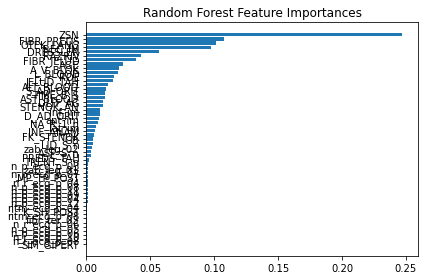

In [25]:
feature_names = X_train.columns.values
tree_feature_importances = rf_grid_best.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

### 2.2) Ensamble - XGBoost

In [28]:
from xgboost import XGBRegressor
from pprint import pprint
from sklearn.model_selection import GridSearchCV
import time

## XGBoostRegressor
modelXGBR = XGBRegressor()


## Creamos la Grilla
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
learning_rate = [0.01,0.1]
max_depth = [i for i in range(2,8,2)]
start = time.time()

random_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'colsample_bytree': [0.2, 0.6, 0.8],
               'min_child_weight': [3, 5, 7],
               'gamma': [0.3, 0.5, 0.7],
               'subsample': [0.4, 0.6, 0.8, 1],
               'learning_rate': learning_rate}

xgb_grid = GridSearchCV(estimator=modelXGBR, 
                   param_grid=random_grid,
                   scoring='r2', 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1      # Paralelizar en todos los cores disponibles
)


print('Los valores a probar en la busqueda por grilla son:')
pprint(xgb_grid)


xgb_grid.fit(X_train, y_train)

## Tomamos el mejor estimador encontrado en la búsqueda por grilla.
xgb_best_model = xgb_grid.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(xgb_grid.best_params_)
print()


score_XGBR_train = xgb_best_model.score(X_train, y_train)
score_XGBR_val = xgb_best_model.score(X_val, y_val)
print("*"*100)
print(f"Exactitud luego de búsqueda en grilla en entrenamiento: {score_XGBR_train:.3f}")
print(f"Exactitud luego de búsqueda en grilla en validación: {score_XGBR_val:.3f}")

end = time.time()
print(end-start)

Los valores a probar en la busqueda por grilla son:
GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None

KeyboardInterrupt: 

### 2.3) Ensamble - SVM

In [40]:
from sklearn import svm
#Entrenamos el árbol de Decisión - Regresión

modelSVM = svm.SVC()

modelSVM.fit(X_train, y_train)
score_SVM_train = modelSVM.score(X_train, y_train)
score_SVM_test = modelSVM.score(X_val, y_val)

print(f"R^2: {score_SVM_train}")
print(f"R^2: {score_SVM_test}")

X_train = pd.read_csv(data1)
X_val = pd.read_csv(data2)
y_train = pd.read_csv(data3)
y_val = pd.read_csv(data4)

C:\Users\romme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R^2: 0.861764705882353
R^2: 0.4823529411764706


In [43]:
#Entrenamos el árbol de Decisión - Regresión
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

modelDTR = DecisionTreeRegressor(max_depth=5)
modelDTR.fit(X_train, y_train)

score_DTR_train = modelDTR.score(X_train, y_train)
score_DTR_test = modelDTR.score(X_val, y_val)

print(f"R^2: {score_DTR_train}")
print(f"R^2: {score_DTR_test}")

R^2: 0.9990409972693562
R^2: 0.9984955142449908
